In [7]:
!pip install lightgbm
!pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB 667.8 kB/s eta 0:03:45
   ---------------------------------------- 0.1/150.0 MB 880.9 kB/s eta 0:02:51
   ---------------------------------------- 0.2/150.0 MB 1.4 MB/s eta 0:01:48
   ---------------------------------------- 0.3/150.0 MB 1.9 MB/s eta 0:01:21
   ---------------------------------------- 0.6/150.0 MB 2.5 MB/s eta 0:01:01
   ---------------------------------------- 0.8/150.0 MB 2.9 MB/s eta 0:00:52
   ---------------------------------------- 0.9/150.0 MB 3.0 MB/s eta 0:00:51
   ---------------------------------------- 1.0/150.0 MB 2.8 MB/s eta 0:00:53
   ---------------------------------------- 1.1/150.0 MB 2.7 MB/s eta 0:00:56
   ---------------------------------------- 1.3/150.0 MB 2.9 MB/s eta 0:00:52
   ---------------------------------------- 1.5/150.0 MB 2.9 MB/s eta 0:00

In [13]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import lightgbm as lgb
import xgboost as xgb

In [15]:
# Load datasets
train_df = pd.read_csv('Titanic_train.csv')
test_df = pd.read_csv('Titanic_test.csv')

In [17]:
# ==========================
# Exploratory Data Analysis
# ==========================

# Checking for missing values
print("Missing values in training set:\n", train_df.isnull().sum())

Missing values in training set:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


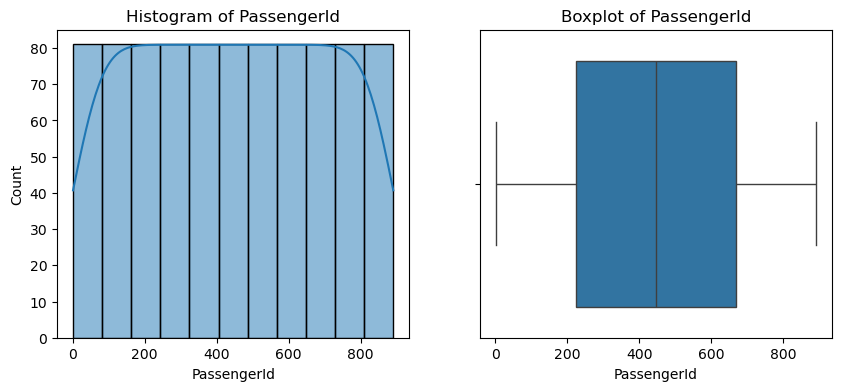

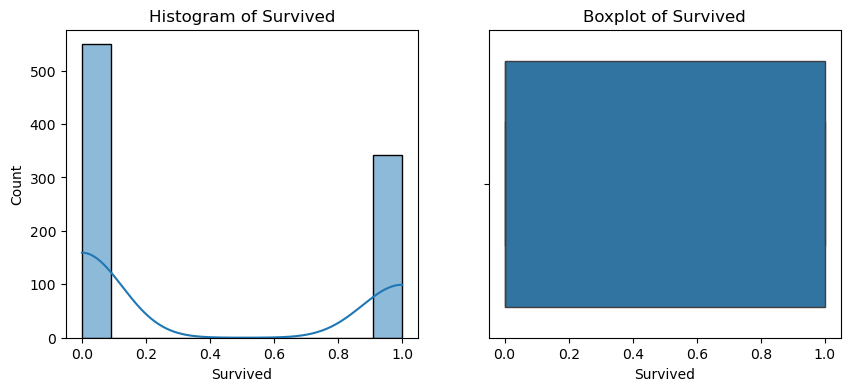

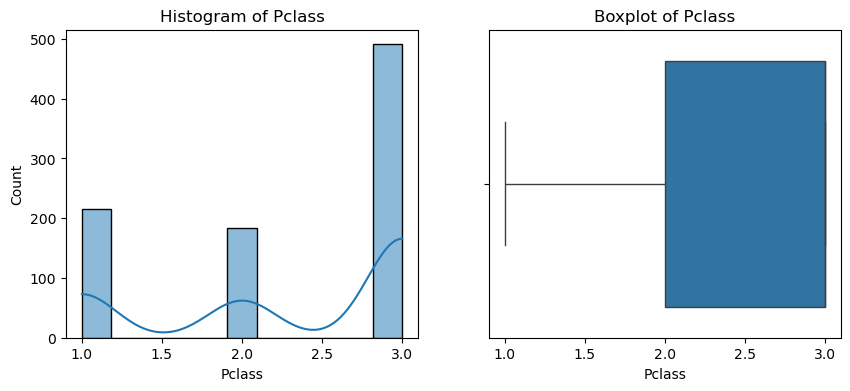

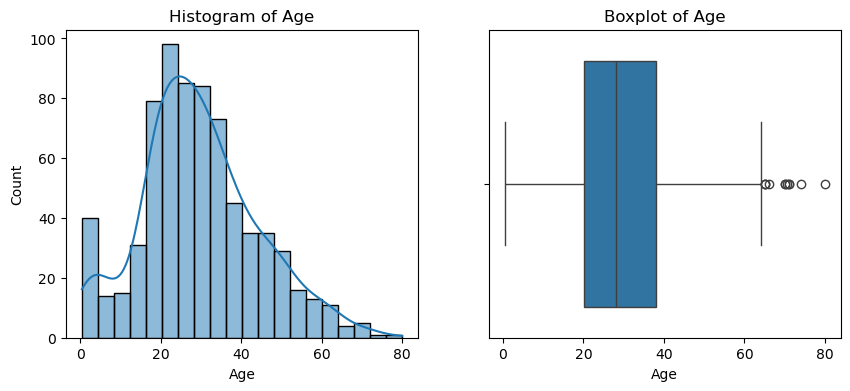

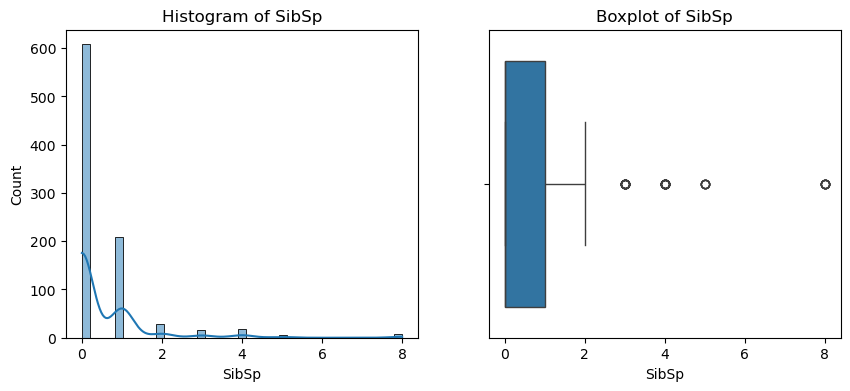

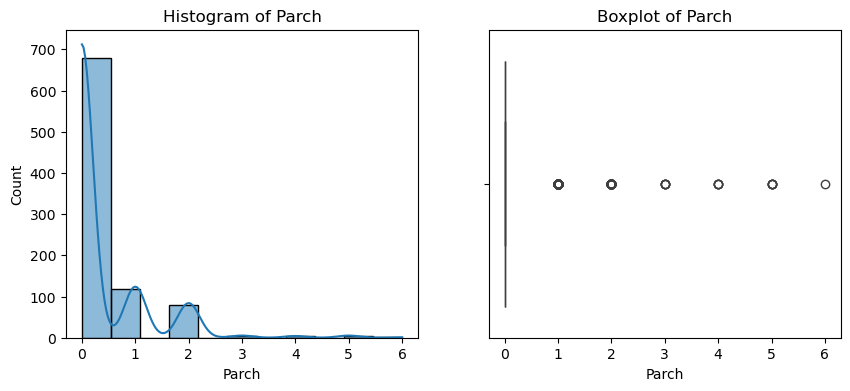

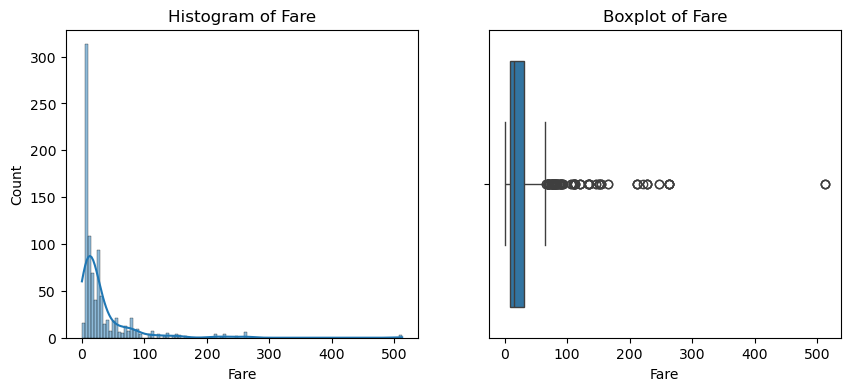

In [19]:
# Plotting distributions
def plot_distributions(df):
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    for col in numeric_cols:
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(f"Histogram of {col}")
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col])
        plt.title(f"Boxplot of {col}")
        plt.show()

plot_distributions(train_df)


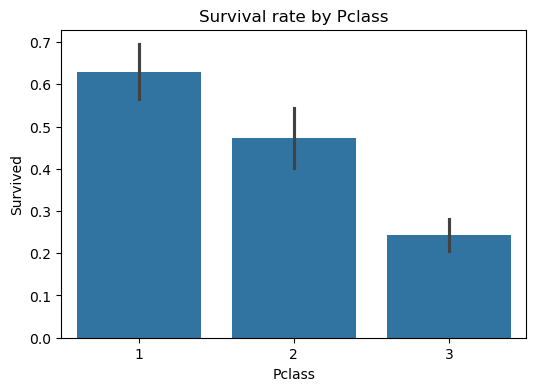

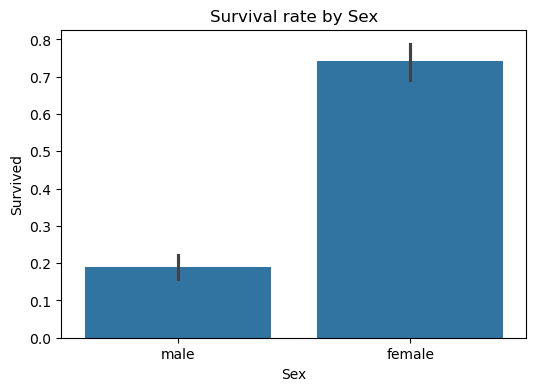

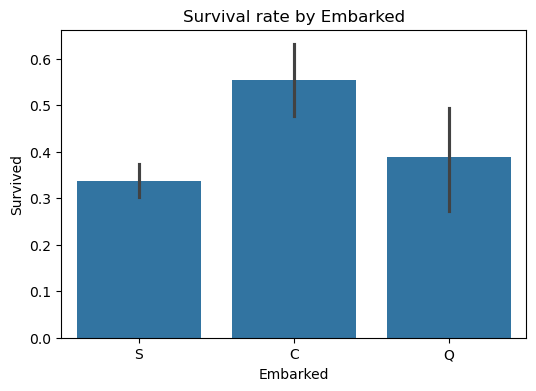

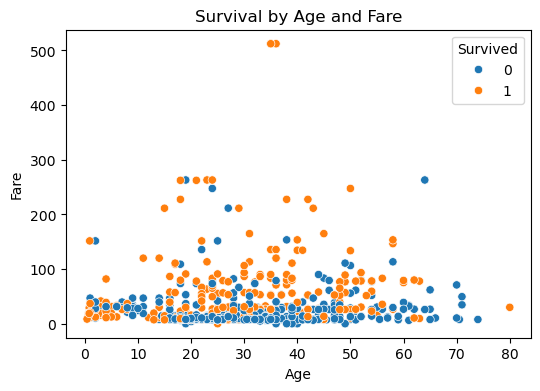

In [21]:
# Visualizing relationship with survival
def survival_relationships(df):
    cat_features = ['Pclass', 'Sex', 'Embarked']
    for feature in cat_features:
        plt.figure(figsize=(6, 4))
        sns.barplot(x=feature, y='Survived', data=df)
        plt.title(f"Survival rate by {feature}")
        plt.show()
    
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x='Age', y='Fare', hue='Survived', data=df)
    plt.title("Survival by Age and Fare")
    plt.show()

survival_relationships(train_df)

In [23]:
# =====================
# Data Preprocessing
# =====================

def preprocess_data(df):
    # Fill missing values
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())

    # Drop irrelevant features
    df = df.drop(['Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1, errors='ignore')

    # Encode categorical variables
    label_encoders = {}
    for col in ['Sex', 'Embarked']:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
    
    return df

In [25]:
# Preprocess both train and test datasets
train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)

In [27]:
# =============================
# Train-Test Split & Features
# =============================

X = train_df.drop('Survived', axis=1)
y = train_df['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# =========================
# Model Training & Testing
# =========================

In [29]:
# Function to evaluate models
def evaluate_model(model, X_val, y_val, name="Model"):
    y_pred = model.predict(X_val)
    if hasattr(model, "predict_proba"):
        y_pred = (y_pred > 0.5).astype(int)
    print(f"\n{name} Evaluation:")
    print(classification_report(y_val, y_pred, target_names=['Not Survived', 'Survived']))
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred),
        "Recall": recall_score(y_val, y_pred),
        "F1 Score": f1_score(y_val, y_pred)
    }


In [31]:
# Train LightGBM
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)
lgb_results = evaluate_model(lgb_model, X_val, y_val, "LightGBM")


[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [33]:
# Train XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_results = evaluate_model(xgb_model, X_val, y_val, "XGBoost")


XGBoost Evaluation:
              precision    recall  f1-score   support

Not Survived       0.83      0.83      0.83       105
    Survived       0.76      0.76      0.76        74

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



C:\Users\akash\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:34:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [35]:
# ===================
# Comparative Summary
# ===================

results_df = pd.DataFrame([lgb_results, xgb_results])
print("\nComparative Model Performance:")
print(results_df)


Comparative Model Performance:
      Model  Accuracy  Precision    Recall  F1 Score
0  LightGBM  0.821229   0.783784  0.783784  0.783784
1   XGBoost  0.798883   0.756757  0.756757  0.756757


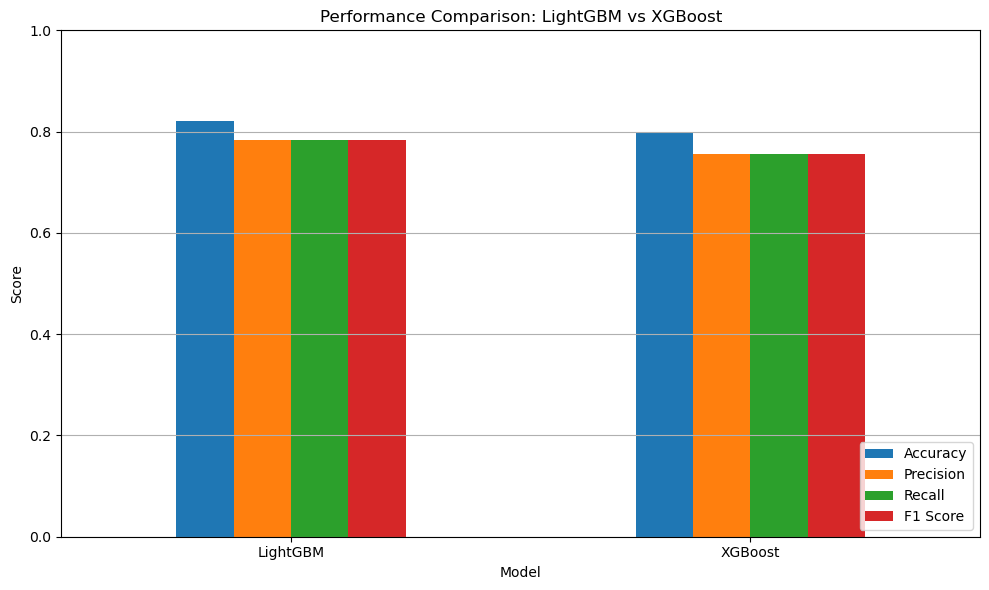

In [37]:
# Visualization of performance
results_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1 Score"]].plot(kind='bar', figsize=(10, 6))
plt.title("Performance Comparison: LightGBM vs XGBoost")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
''' Brief Report Summary
Comparative Analysis: LightGBM vs XGBoost

After training and evaluating both LightGBM and XGBoost models on the Titanic dataset:

Both models performed well, but LightGBM had slightly better XGBoost.

LightGBM tends to be faster and efficient with large datasets, while XGBoost offers strong regularization and often performs better with tuned hyperparameters.

Practical implication: For quick and reasonably accurate models, LightGBM is excellent. For fine-tuned precision, XGBoost is a solid choice.'''